In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [35]:
import glob
import warnings
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot
from utils.utils import midPoint, stride, rolling_std, radialMask
from zernikies import zernikeWLS, getZernikeCoeffs
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [135]:
from scipy.optimize import least_squares

def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
        b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
        bounds = (b1, b2)
    
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    f_scale = 1.0

    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol)
    return r

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
    
    return fit, mask

In [136]:
n = 512
iters = 2
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [234]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
orgData, cleanData = loadLeicaData(refScan, n=None, numpy=False)
xr = orgData[0]
yr = orgData[1]
zr = orgData[2]
xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n)
xrg, yrg, zrg = shiftRotateXYZ(xrg, yrg, zrg, [0, 0, 0, 0, 0, np.deg2rad(178)])
fitr, refMask = parabolaFitIterations(xrg, yrg, zrg, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=iters)
corr = np.hstack((-1*fitr.x[1:4],fitr.x[4:],0))
xrgdr, yrgdr, zrgdr = shiftRotateXYZ(xrg, yrg, zrg, corr)
zrgdr[refMask] = np.nan
tht = np.arctan2(np.nanmax(zrgdr)-np.nanmin(zrgdr), np.nanmax(yrgdr)-np.nanmin(yrgdr))
xrgr, yrgr, zrgr = shiftRotateXYZ(xrgdr, yrgdr, zrgdr, [0, 0, 0, -tht, 0, 0])
zp = parabola(xrgdr, yrgdr, fitr.x[0])
_, _, zpr = shiftRotateXYZ(xrgdr, yrgdr, zp, [0, 0, 0, -tht, 0, 0])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rDiff = sigma_clip(zrgr - zpr)

CPU times: user 2min 13s, sys: 1min 56s, total: 4min 10s
Wall time: 17.3 s


In [235]:
%%time

# Use the .zernike.fits files to select signal scans.
fitsDir = '/home/gbtdata/TLASSI_200315'
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

zFitDict = {}

from astropy.convolution import Gaussian2DKernel, convolve
kernel = Gaussian2DKernel(x_stddev=4)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,ff in enumerate(zern_files):
        
        time = Time( '{0}T{1}'.format('-'.join(ff.split('/')[-1].split('.')[0].split("_")[:3]), 
                                  ff.split('/')[-1].split('.')[0].split("_")[-1]) )
        mjd = time.mjd

        sf = ff.replace(".zernike.fits", ".fits")
        sigScanFile = "{0}/{1}".format(scanDir, sf.split('/')[-1].replace('.fits', '.ptx.csv'))

        # Find the scan number.
        hdu = fits.open(sf)
        head = hdu[0].header
        scan = head['SCAN']

        orgData, cleanData = loadLeicaData(sigScanFile, n=n, numpy=False)
        xs = orgData[0]
        ys = orgData[1]
        zs = orgData[2]

        xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n)#, xmin=xMin, xmax=xMax, ymin=yMin, ymax=yMax)
        xsg, ysg, zsg = shiftRotateXYZ(xsg, ysg, zsg, [0, 0, 0, 0, 0, np.deg2rad(178)])
        
        lb = [fitr.x[0]-1e-6, -10, -10, -55, -np.pi, -np.pi]
        ub = [fitr.x[0]+1e-6,  10,  10, -45,  np.pi,  np.pi]
        bounds = (lb, ub)
        #bounds = None
        fitS, sigMask = parabolaFitIterations(xsg, ysg, zsg, 
                                              guess=[fitr.x[0], 0, 0, -50., 0, 0], 
                                              bounds=bounds, iters=iters)
        cors = np.hstack((-1*fitr.x[1:4],fitr.x[4:],0))
        xsgdr, ysgdr, zsgdr = shiftRotateXYZ(xsg, ysg, zsg, cors)
        zsgdr[sigMask] = np.nan
        tht = np.arctan2(np.nanmax(zsgdr)-np.nanmin(zsgdr), np.nanmax(ysgdr)-np.nanmin(ysgdr))
        xsgr, ysgr, zsgr = shiftRotateXYZ(xsgdr, ysgdr, zsgdr, [0, 0, 0, -tht, 0, 0])
        zp = parabola(xsgdr, ysgdr, fitr.x[0])
        _, _, zpr = shiftRotateXYZ(xsgdr, ysgdr, zp, [0, 0, 0, -tht, 0, 0])
        sDiff = sigma_clip(zsgr - zpr)
        #sDiff = sigma_clip(zsgdr - zp)
        
        #xmin, xmax = gridLimits(xsgdr, xrgdr)
        #ymin, ymax = gridLimits(ysgdr, yrgdr)

        #xsf, ysf, zsf = regridXYZMasked(xsgdr, ysgdr, sDiff, n=n, xmax=xmax, xmin=xmin, ymax=ymax, ymin=ymin)
        #xrf, yrf, zrf = regridXYZMasked(xrgdr, yrgdr, rDiff, n=n, xmax=xmax, xmin=xmin, ymax=ymax, ymin=ymin)

        diff = sigma_clip(sDiff - rDiff, 5)
        xDiff = xsgr
        yDiff = ysgr

        diffSmo = convolve(diff, kernel, preserve_nan=False)
        diffSmo = np.ma.masked_where(diff.mask, diffSmo)

        diff_ = np.ma.copy(diffSmo)
        diff_[~radialMask(xDiff, yDiff, 49.5)] = np.nan
        diff_ = np.ma.masked_invalid(diff_)

        fl = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')

        fl_wls = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)

        zFitDict[scan] = {'recovered zernike': fl,
                          'recovered zernike wls': fl_wls,
                          'parabola fir coefficients': fitS.x,
                          'deformation map z': diff,
                          'deformation map x': xDiff,
                          'deformation map y': yDiff,
                          'mjd': mjd
                         }

CPU times: user 42min, sys: 36min 56s, total: 1h 18min 56s
Wall time: 5min 14s


In [181]:
import pickle
outputDict = "zFitDict_2d.pickle"
pickle.dump( zFitDict, open( outputDict, "wb" ) )

In [6]:
%%time

asDict = {}

# Use the .zernike.fits files to select signal scans.
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

# Load the ScanLog
hdu = fits.open("{0}/ScanLog.fits".format(fitsDir))
scanArr = hdu[1].data

for i, zf in enumerate(zern_files):
    
    hdu = fits.open(zf)
    head = hdu[0].header
    scan = head['MC_SCAN']

    idx = np.where(scanArr['SCAN'] == scan)[0][0]
    idx_as = idx - 3
    sig_scan = scanArr['SCAN'][idx_as]
    ref_scan = scanArr['SCAN'][idx_as-6]

    # Load the AS fits file for the signal scan.
    as_file = file = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    hdu = fits.open("{0}/{1}".format(fitsDir, as_file))
    z_as = hdu[1].data['value']

    # The AS Zernike contents start at Z1, not Z0.
    # The LASSI Zernike start at Z0.
    z_idx = int(np.where(z_as != 0)[0])

    as_file_sig = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    as_file_ref = '/'.join(scanArr[idx_as - 6]['FILEPATH'].split('/')[-2:])
    #print(as_file_sig, as_file_ref)
    xas, yas, aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/{1}".format(fitsDir, as_file_ref), 
                                                               "{0}/{1}".format(fitsDir, as_file_sig), 
                                                               column='ABSOLUTE', filterDisabled=True, 
                                                               verbose=False, plot=False)
    z_as_obs = fitlist

    z_in = z_as[z_idx]
    z_in_as = z_as_obs[z_idx+1]*1e6 # microns

    asDict[scan] = {'input zernike': z_idx + 1,
                    'input zernike value': z_as[z_idx],
                    'active surface zernike value': z_in_as,
                    'active surface reference scan': ref_scan,
                    'active surface signal scan': sig_scan,
                     }

CPU times: user 30.6 s, sys: 2.7 s, total: 33.3 s
Wall time: 28.9 s


In [7]:
%%time
zindxs = [4, 7, 13]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256)

CPU times: user 44.8 s, sys: 33.8 ms, total: 44.8 s
Wall time: 44.8 s


In [236]:
%%time

zin = np.zeros(len(zern_files), dtype=np.float)
mjds = np.zeros(len(zern_files), dtype=np.float)
zobs = np.zeros((len(zern_files),2), dtype=np.float)
zinval = np.zeros(len(zern_files), dtype=np.float)
residuals = np.zeros((len(zern_files),2), dtype=np.float)

for i,k in enumerate(natsorted(list(zFitDict.keys()))):
    
    zi = asDict[k]['input zernike']
    ci = asDict[k]['active surface zernike value']
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    ci_obs_wls = zFitDict[k]['recovered zernike wls'][zi]
    mjds[i] = zFitDict[k]['mjd']
    
    zin[i] = zi
    zinval[i] = ci
    zobs[i,0] = ci_obs
    zobs[i,1] = ci_obs_wls
    residuals[i,0] = abs(ci - ci_obs)
    residuals[i,1] = abs(ci - ci_obs_wls)

CPU times: user 657 µs, sys: 550 µs, total: 1.21 ms
Wall time: 1.22 ms


In [237]:
%%time
time = Time(mjds, format='mjd')
eta_as = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, np.asarray(zindxs), np.zeros(len(zindxs)), np.ones(len(zindxs))*25.)
eta_res = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,0]*1e6)
eta_res_wls = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,1]*1e6)
eta_res_comb = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs.mean(axis=1)*1e6)

CPU times: user 1.2 ms, sys: 2.88 ms, total: 4.08 ms
Wall time: 3.11 ms


In [238]:
eta_as

array([0.20725998, 0.20652371, 0.19349818])

<IPython.core.display.Javascript object>


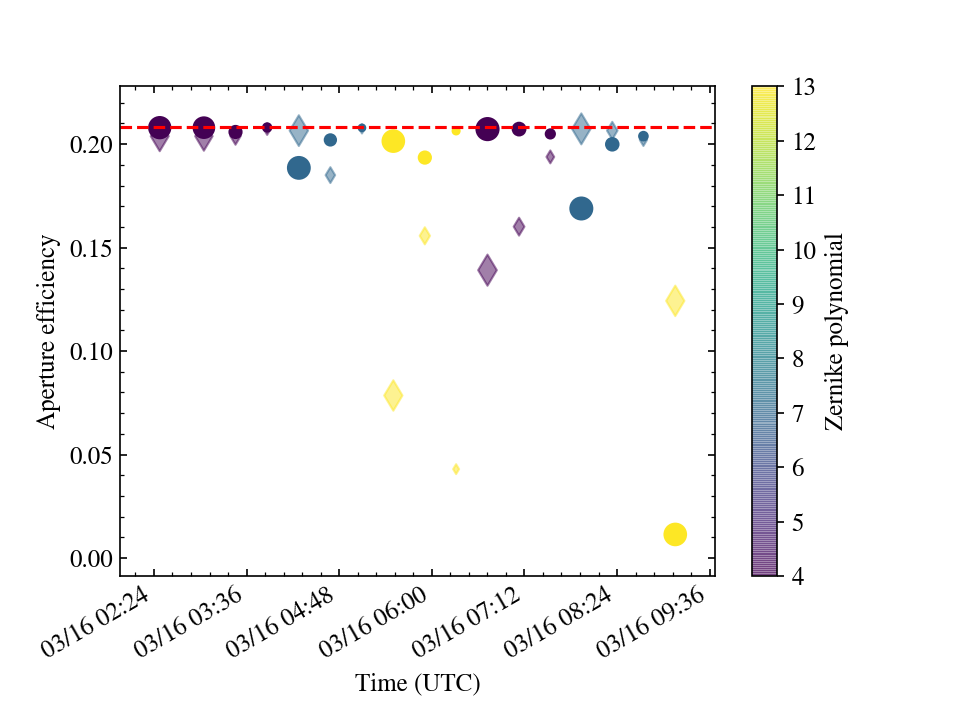

In [244]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(dpi=150, frameon=False)

ax = fig.add_subplot(111)
#axt = ax.twiny()

ax.axhline(y=np.max(eta_tot), color='r', linestyle='--')
#for eas in eta_as:
#    ax.axhline(y=eas, color='k', linestyle='--')

sc = ax.scatter(time.plot_date, eta_res, c=zin, s=abs(zinval)/5., marker='o')
sc = ax.scatter(time.plot_date, eta_res_wls, c=zin, s=abs(zinval)/5., marker='d', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_comb, c=zin, s=abs(zinval)/5., marker='o')
cb = plt.colorbar(sc)
cb.set_label('Zernike polynomial')
ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
#ax.set_xlabel("Scan")
ax.set_ylabel("Aperture efficiency")

ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time (UTC)')

fig.autofmt_xdate()


#plt.savefig("eta_scan_avgrefsimple.pdf", bbox_inches='tight', pad_inches=0.06)

In [258]:
idx = 9
print(zin[idx], zinval[idx], zobs[idx]*1e6, zobs[idx].mean()*1e6)

13.0 -56.622425968596474 [-41.99426575  87.4320475 ] 22.71889087360701


In [241]:
print(np.max(eta_tot), np.mean(eta_res), np.power(np.mean(eta_res)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res[:7],eta_res[8:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.20804304085861067 0.1901785462264766 1.1966946228002069
0.20804304085861067 0.1894741832277041 1.2056084931408693


In [242]:
print(np.max(eta_tot), np.mean(eta_res_wls), np.power(np.mean(eta_res_wls)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res_wls[:8],eta_res_wls[10:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.20804304085861067 0.17223161540529436 1.459085145570947
0.20804304085861067 0.18195540637367888 1.3073036018182804


In [243]:
print(np.max(eta_tot), np.mean(eta_res_comb), np.power(np.mean(eta_res_comb)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res_comb[:7],eta_res_comb[8:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.20804304085861067 0.19253919378063525 1.1675301059182623
0.20804304085861067 0.193941283641301 1.1507099132467644


In [223]:
zinval[0:2].mean(), zobs[0:2].mean()*1e6, eta_res_wls[0:2].mean()

(-502.3620250443295, -244.68247568540065, 0.1681879714300329)

In [257]:
zern_files[8]

'/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_05:54:35.zernike.fits'

In [48]:
list(zFitDict.keys())[10]

81

In [49]:
asDict[81]

{'input zernike': 4,
 'input zernike value': 500.0,
 'active surface zernike value': -560.7736237001722,
 'active surface reference scan': 78,
 'active surface signal scan': 80}

In [85]:
hdu = fits.open('/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_05:54:35.fits')
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'NRAO Green Bank'    /                                                
INSTRUME= 'LASSI   '           / device or program of origin                    
GBTMCVER= '19.4    '           / telescope control software release             
FITSVER = '2.1     '           / FITS definition version for this device        
DATEBLD = 'DATEBLD  goes  here' / time program was linked                       
SIMULATE=                    0 / Is the instrument in simulate mode?            
DATE-OBS= '2020-03-16T05:54:

In [208]:
aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, np.array([4]), np.array([-502]), np.array([-335]))

array([0.1843163])

In [210]:
eta_res_wls[0:4]

array([0.17294351, 0.16343244, 0.18932583, 0.17594018])